In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mindspore import Tensor, context, dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
import mindspore.nn as nn
import mindspore.ops as ops

In [30]:


context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

# 加载MNIST数据集
def load_data():
    train_data = ds.MnistDataset(dataset_dir='.', usage='train')
    test_data = ds.MnistDataset(dataset_dir='.', usage='test')

    # 数据处理
    transform = [
        CV.Resize((28, 28)),
        CV.Rescale(1.0 / 255.0, 0.0),
        CV.Rescale(2.0, -1.0),  # 转换为[-1, 1]
        CV.HWC2CHW()
    ]
    type_cast_op = C.TypeCast(mstype.int32)

    train_data = train_data.map(operations=type_cast_op, input_columns="label")
    test_data = test_data.map(operations=type_cast_op, input_columns="label")

    train_data = train_data.map(operations=transform, input_columns="image")
    test_data = test_data.map(operations=transform, input_columns="image")

    # 批处理和打乱数据
    train_data = train_data.batch(64, drop_remainder=True)
    test_data = test_data.batch(64, drop_remainder=True)

    return train_data, test_data

train_data, test_data = load_data()


[WARNING] ME(964:2372,MainProcess):2024-05-23-16:26:37.840.192 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(964:2372,MainProcess):2024-05-23-16:26:37.846.994 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(964:2372,MainProcess):2024-05-23-16:26:37.849.453 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(964:2372,MainProcess):2024-05-23-16:26:37.851.061 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from m

In [31]:
import mindspore.nn as nn
from mindspore import context, dtype as mstype
import mindspore.ops as ops

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

class OptimizedMultinomialNaiveBayes(nn.Cell):
    def __init__(self, alpha=1.0):
        super(OptimizedMultinomialNaiveBayes, self).__init__()
        self.alpha = alpha
        self.classes = None
        self.class_count = None
        self.feature_count = None
        self.class_log_prior = None
        self.feature_log_prob = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.class_count = np.zeros(n_classes)
        self.feature_count = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_count[idx] = X_c.shape[0]
            self.feature_count[idx, :] = np.sum(X_c, axis=0)

        self.class_log_prior = np.log(self.class_count / np.sum(self.class_count))
        self.feature_log_prob = np.log((self.feature_count + self.alpha) / (self.class_count[:, None] + self.alpha * n_features))

    def construct(self, X):
        log_likelihood = ops.matmul(Tensor(X, mstype.float32), Tensor(self.feature_log_prob.T, mstype.float32))
        log_posterior = log_likelihood + Tensor(self.class_log_prior, mstype.float32)
        return self.classes[np.argmax(log_posterior.asnumpy(), axis=1)]

omnb = OptimizedMultinomialNaiveBayes(alpha=1.0)
omnb.fit(X_train, y_train)
predictions = omnb.construct(X_test)
accuracy = np.mean(predictions == y_test)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6243


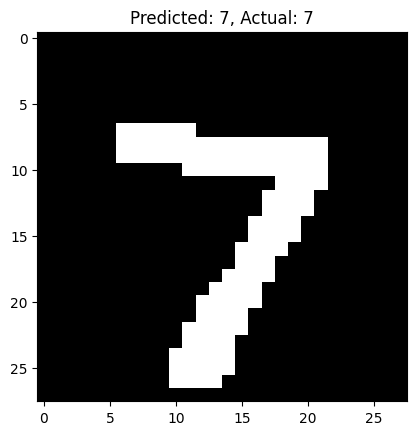

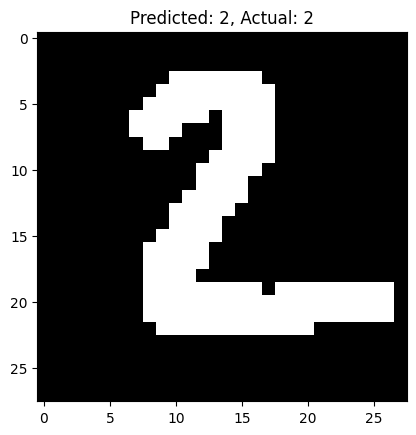

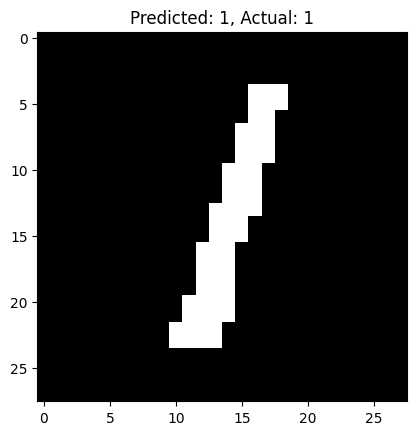

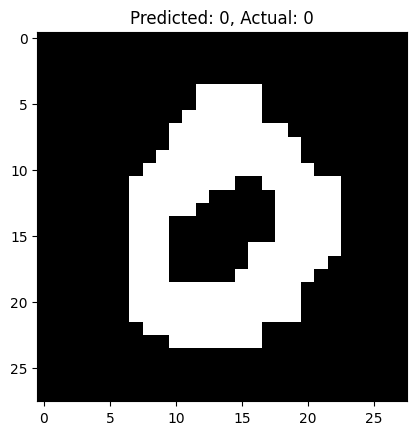

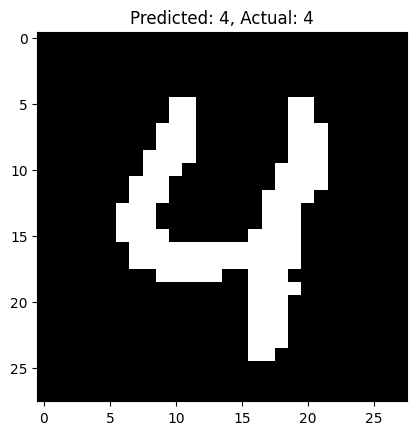

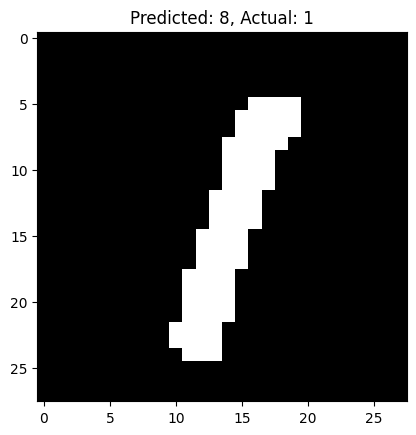

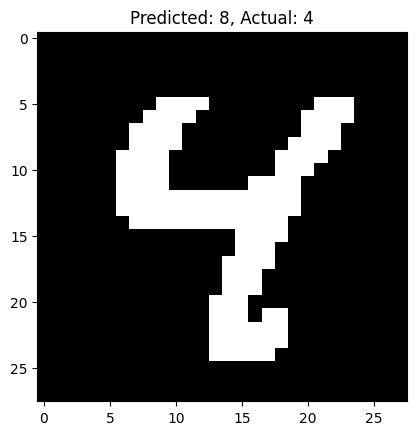

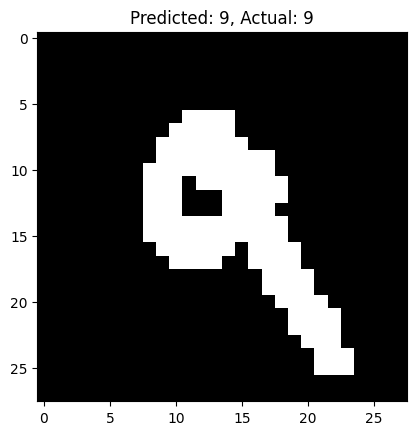

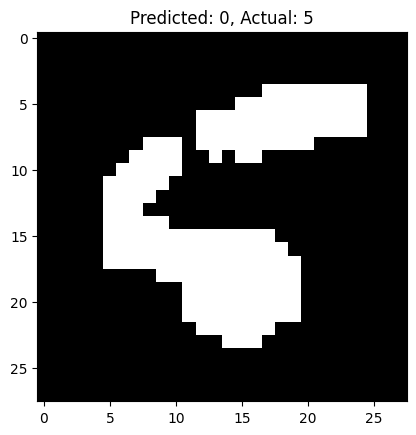

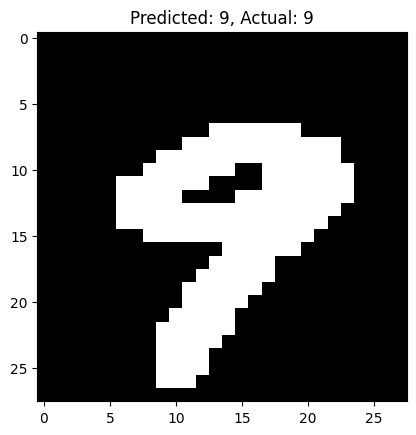

In [32]:
for i in range(10):
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predictions[i]}, Actual: {y_test[i]}')
    plt.show()
